In [97]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.draw import line, circle_perimeter, line_aa, ellipse_perimeter
from skimage.feature import canny
import copy
from math import atan2
from skimage.transform import resize
from image_transformations import *
from time import time

In [98]:
def plot_grayscale_pic(picture, fig_width=7, fig_length=7):
    plt.figure(figsize=(fig_width,fig_length))
    plt.imshow(picture, cmap=plt.get_cmap("gray"), vmin=0.0, vmax=1.0)
    plt.show()
    
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

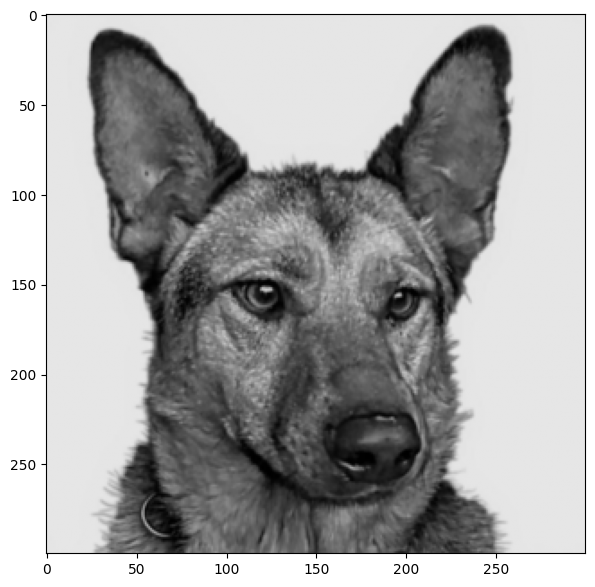

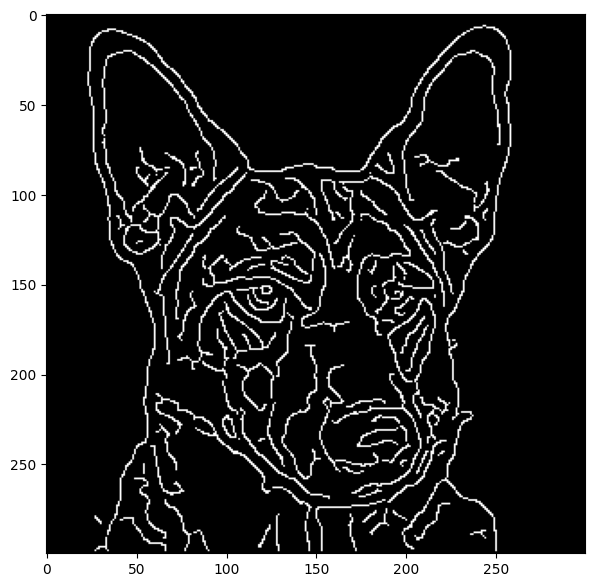

In [110]:
LONG_SIDE = 300
name_img = "cerati.jpeg"
img = mpimg.imread('input/'+name_img)
img = largest_square(img)
img = resize(img, (LONG_SIDE, LONG_SIDE))

orig_pic = rgb2gray(img)

edges = canny(orig_pic, sigma=2)
# orig_pic[edges] = 0.3
orig_pic = orig_pic*0.9

plot_grayscale_pic(orig_pic)
plot_grayscale_pic(edges)

In [100]:
orig_pic[0][:5]

array([0.89638094, 0.89638094, 0.89638094, 0.89638094, 0.89638094])

In [101]:
def create_rectangle_nail_positions(picture, nail_step=2):
    height = len(picture)
    width = len(picture[0])
    
    nails_top = [(0, i) for i in range(0, width, nail_step)]
    nails_bot = [(height-1, i) for i in range(0, width, nail_step)]
    nails_right = [(i, width-1) for i in range(1, height-1, nail_step)]
    nails_left = [(i, 0) for i in range(1, height-1, nail_step)]
    nails = nails_top + nails_right + nails_bot + nails_left
    
    return nails

def create_circle_nail_positions(picture, nail_step=2):
    height = len(picture)
    width = len(picture[0])
    
    centre = (height // 2, width // 2)
    radius = min(height, width) // 2 - 1
    rr, cc = circle_perimeter(centre[0], centre[1], radius)
    nails = list(set([(rr[i], cc[i]) for i in range(len(cc))]))
    nails.sort(key=lambda c: atan2(c[0] - centre[0], c[1] - centre[1]))
    nails = nails[::nail_step]
    
    return nails

def init_black_canvas(picture):
    height = len(picture)
    width = len(picture[0])
    return np.zeros((height, width))

def init_white_canvas(picture):
    height = len(picture)
    width = len(picture[0])
    return np.ones((height, width))

In [102]:
def get_aa_line(from_pos, to_pos, str_strength, picture):
    rr, cc, val = line_aa(from_pos[0], from_pos[1], to_pos[0], to_pos[1])
    line = picture[rr, cc] + str_strength * val
    line = np.clip(line, a_min=0, a_max=1)
    
    return line, rr, cc

def find_best_nail_position(current_position, nails, str_pic, orig_pic, str_strength):

    best_cumulative_improvement = -99999
    best_nail_position = None
    best_nail_idx = None

    for nail_idx, nail_position in enumerate(nails):

        overlayed_line, rr, cc = get_aa_line(current_position, nail_position, str_strength, str_pic)

        before_overlayed_line_diff = np.abs(str_pic[rr, cc] - orig_pic[rr, cc])**2
        after_overlayed_line_diff = np.abs(overlayed_line - orig_pic[rr, cc])**2

        cumulative_improvement =  np.sum(before_overlayed_line_diff - after_overlayed_line_diff)

        if cumulative_improvement >= best_cumulative_improvement:
            best_cumulative_improvement = cumulative_improvement
            best_nail_position = nail_position
            best_nail_idx = nail_idx

    return best_nail_idx, best_nail_position, best_cumulative_improvement

In [103]:
def create_art(nails, orig_pic, str_pic, str_strength):
    
    start = time()
    iter_times = []
    
    current_position = nails[0]
    pull_order = [0]

    i = 0
    while True:
        start_iter = time()
        
        i += 1
        if i > 2500:
            break
        if i % 200 == 0:
            plot_grayscale_pic(str_pic)
        
        idx, best_nail_position, best_cumulative_improvement = find_best_nail_position(current_position, nails,
                                                                                  str_pic, orig_pic, str_strength)
        pull_order.append(idx)
        best_overlayed_line, rr, cc = get_aa_line(current_position, best_nail_position, str_strength, str_pic)
        str_pic[rr, cc] = best_overlayed_line
        
        current_position = best_nail_position
        iter_times.append(time() - start_iter)

    print(f"Time: {time() - start}")
    print(f"Avg iteration time: {np.mean(iter_times)}")
    return pull_order

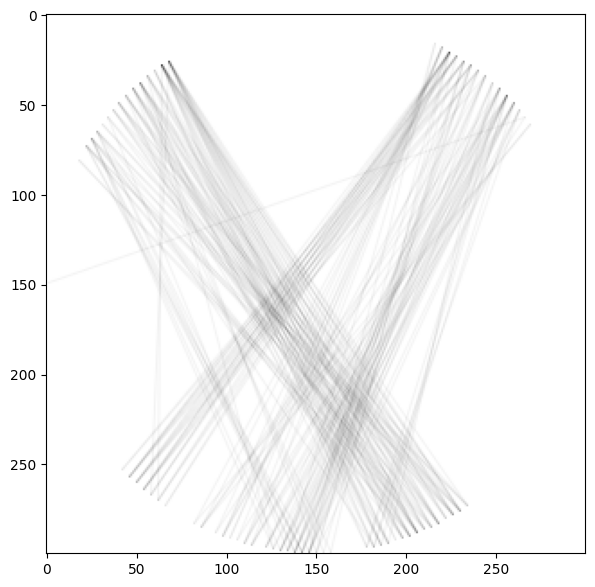

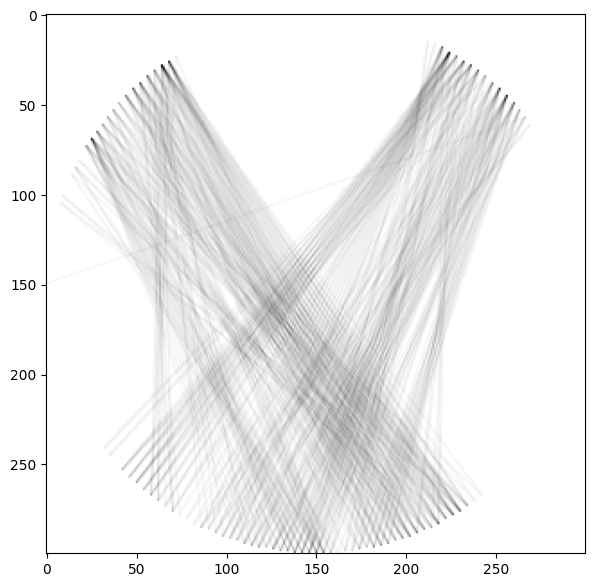

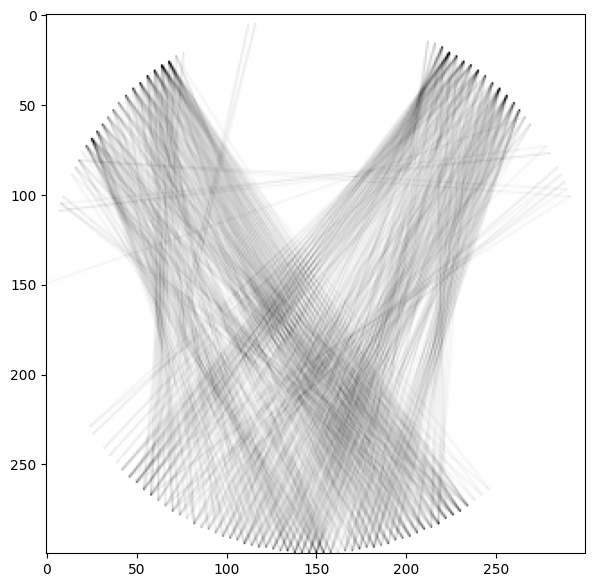

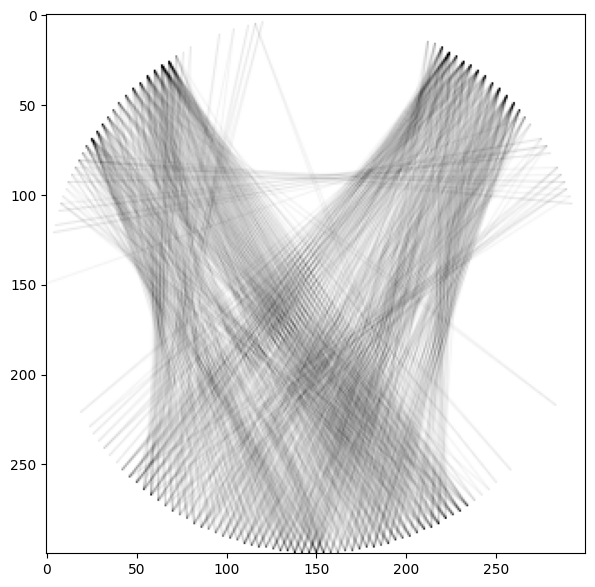

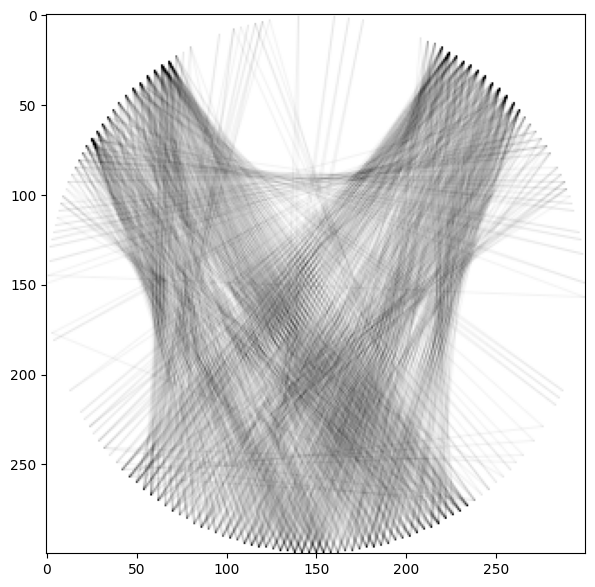

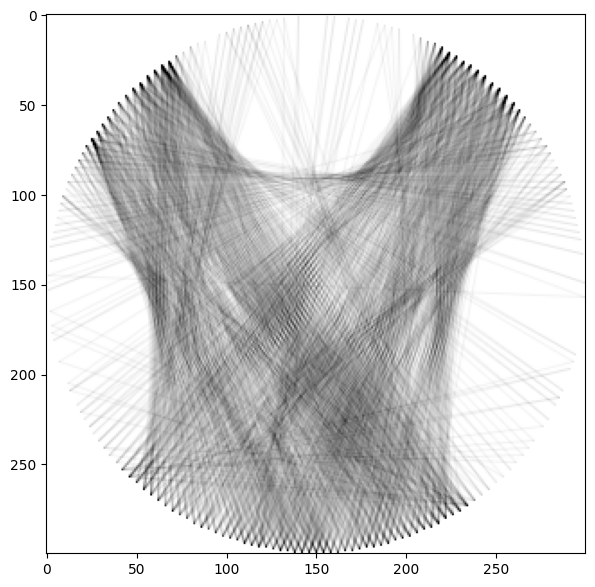

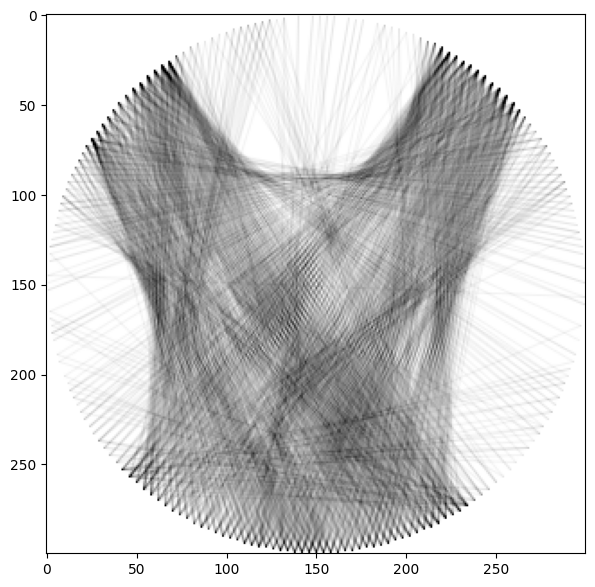

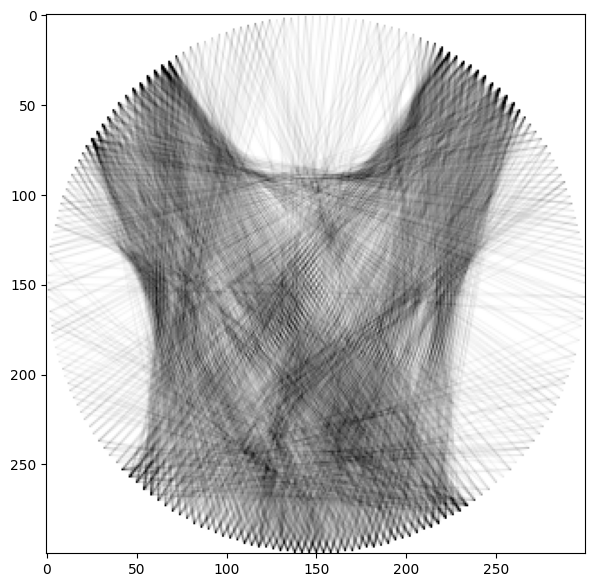

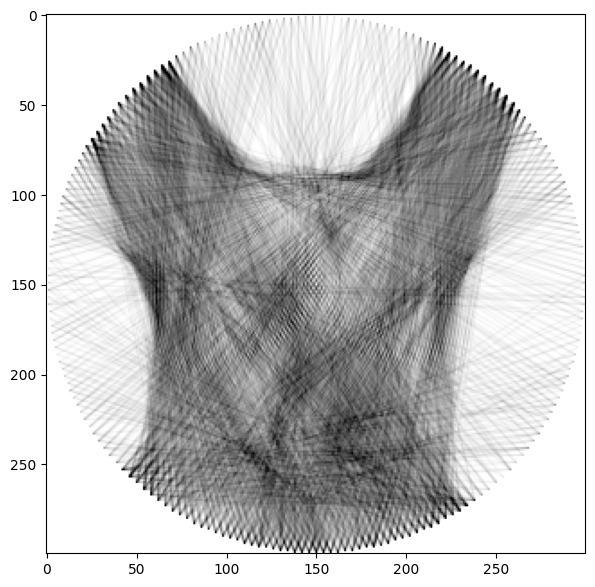

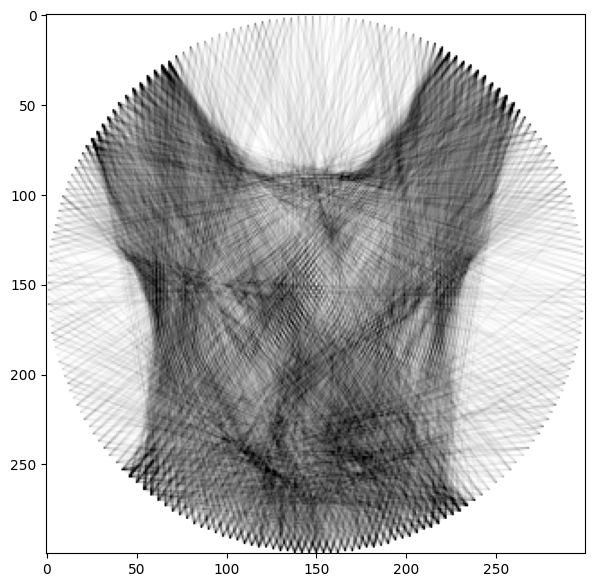

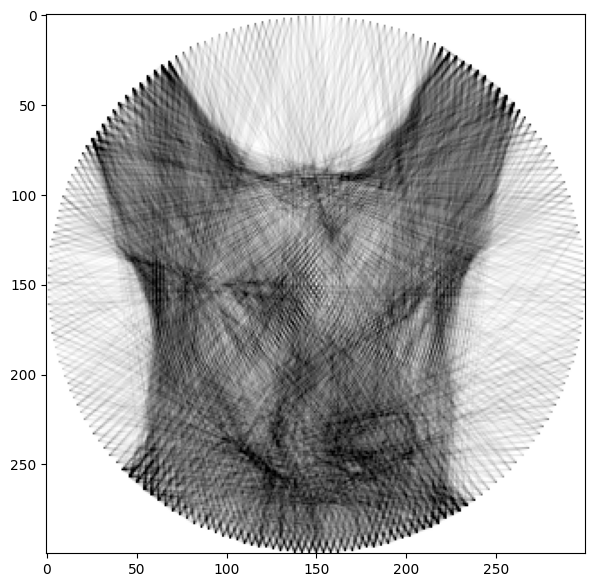

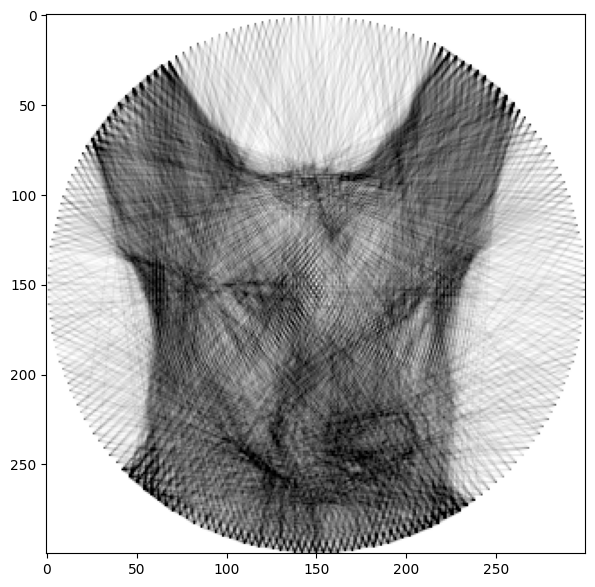

Time: 43.6858651638031
Avg iteration time: 0.017473979663848876


In [104]:
nails = create_circle_nail_positions(orig_pic, 4)
str_pic = init_white_canvas(orig_pic)
#print(f"Valores de nails: {nails}, ori pic: {orig_pic}, str pic: {str_pic}")
pull_order = create_art(nails, orig_pic, str_pic, -0.05)


In [105]:
print(f"Thread pull order by nail index:\n{'-'.join([str(idx) for idx in pull_order])}")

Thread pull order by nail index:
0-82-167-79-163-78-161-75-184-72-182-71-181-72-183-73-158-72-180-71-183-74-160-79-165-78-162-80-164-77-161-74-159-69-162-79-159-78-168-70-170-71-179-72-184-74-182-73-157-27-145-32-144-26-140-31-146-32-148-30-145-28-141-31-138-21-137-24-141-27-148-31-142-32-147-31-150-30-149-31-139-27-144-31-143-23-139-19-138-25-142-28-146-27-149-29-143-32-141-20-160-19-144-28-140-32-139-22-138-31-137-20-145-24-144-29-141-26-145-19-159-71-174-79-150-21-161-80-167-70-171-71-182-75-163-76-165-80-169-70-172-79-151-31-180-73-184-71-175-83-174-78-149-32-181-71-156-26-143-17-142-21-160-77-148-25-146-20-161-79-168-74-185-73-160-80-150-28-158-81-151-28-138-32-144-25-139-29-164-20-163-81-159-76-171-75-183-76-162-23-140-27-158-22-141-70-166-20-168-77-158-78-153-68-152-80-156-74-164-70-174-31-145-29-138-30-141-16-143-27-152-71-178-73-170-78-150-29-165-20-159-21-147-76-185-72-154-79-164-75-172-71-176-78-166-80-151-26-138-20-155-79-148-19-157-31-181-33-149-79-170-75-167-20-162-24-146

In [106]:
print(f"Total de clavos: {max(pull_order)}, total de puntos: {len(pull_order)}")

Total de clavos: 210, total de puntos: 2501


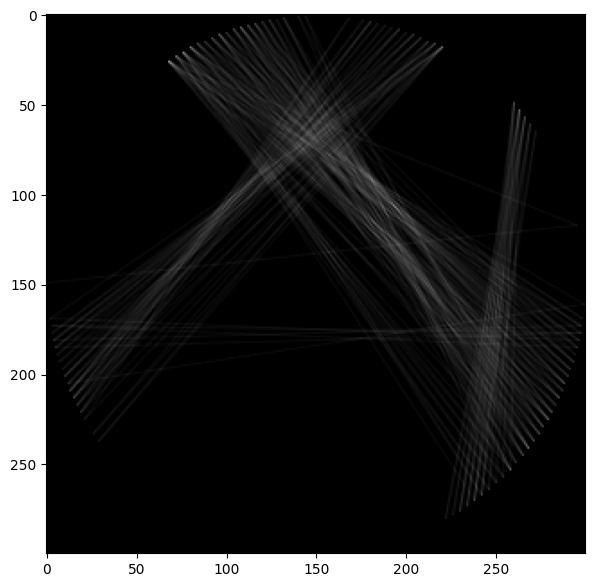

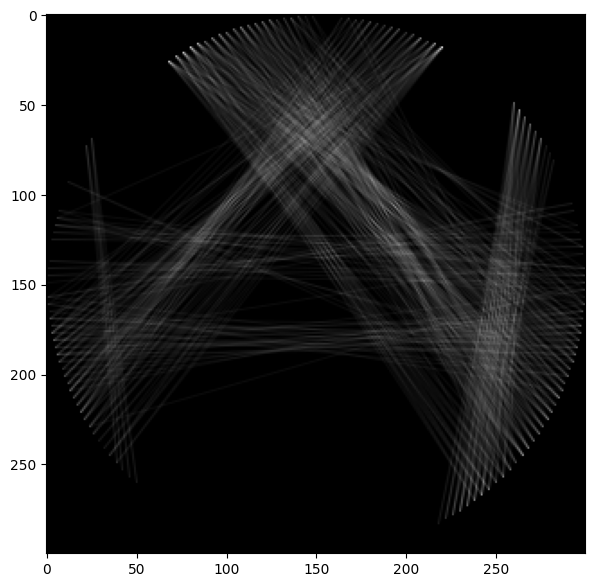

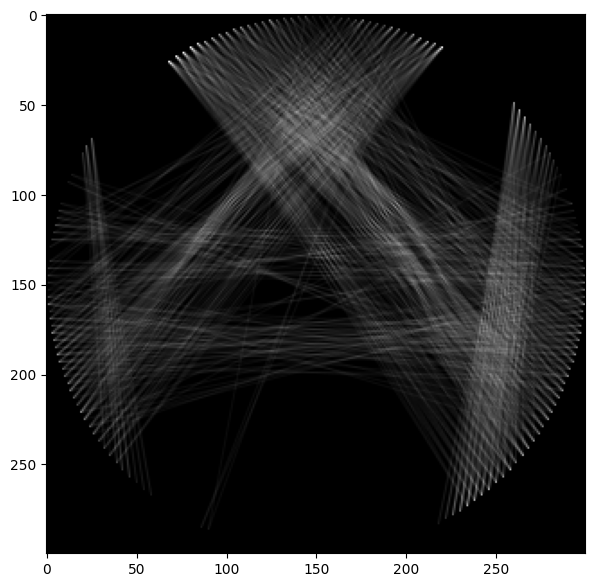

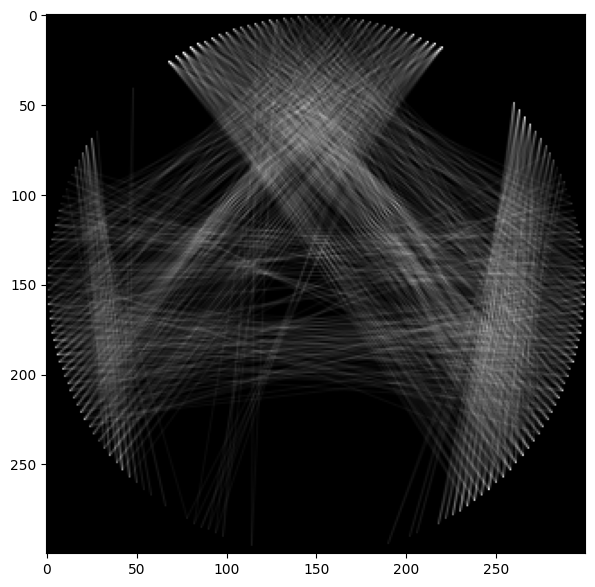

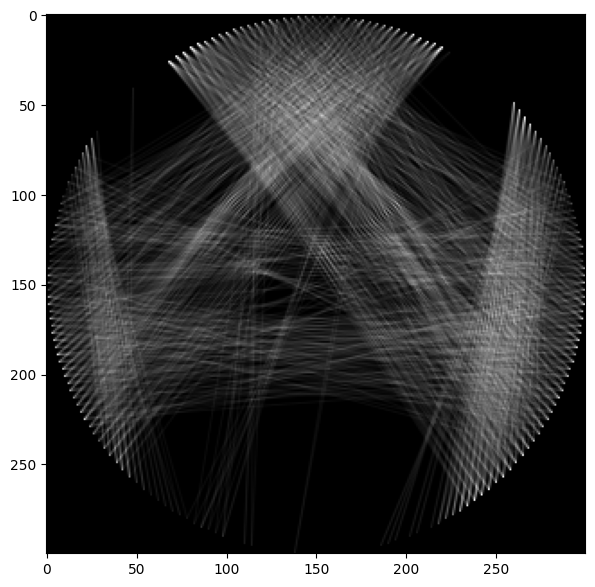

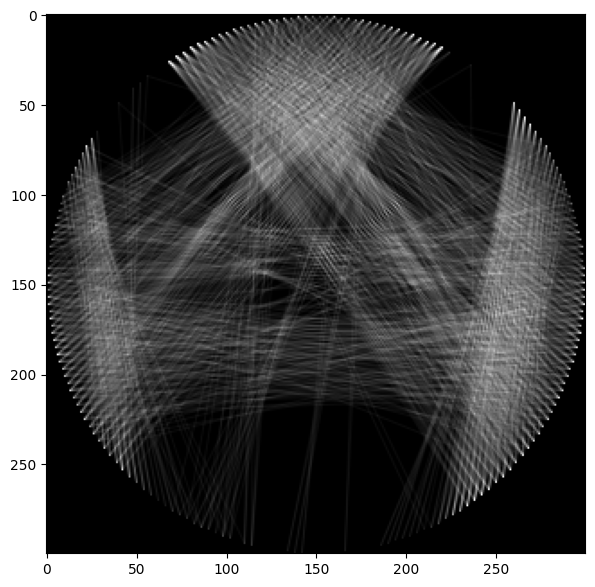

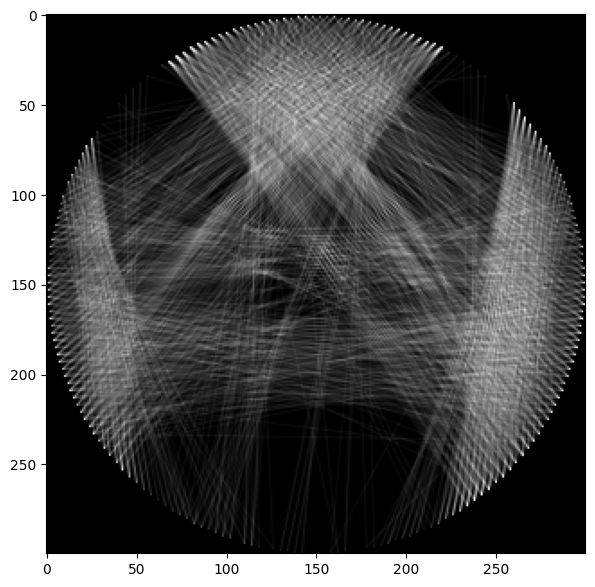

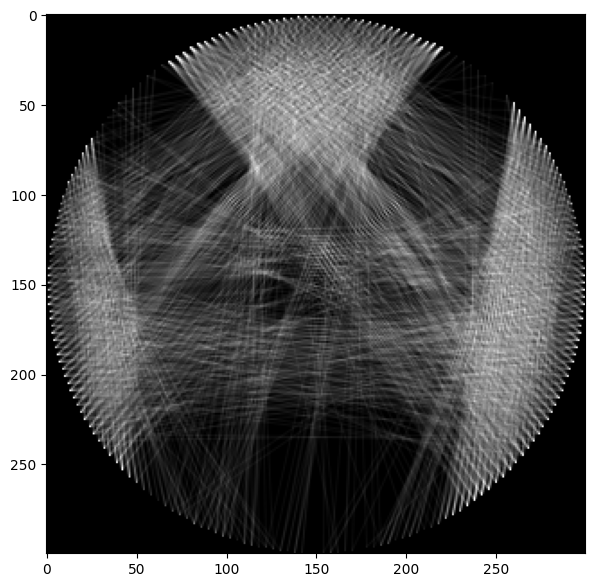

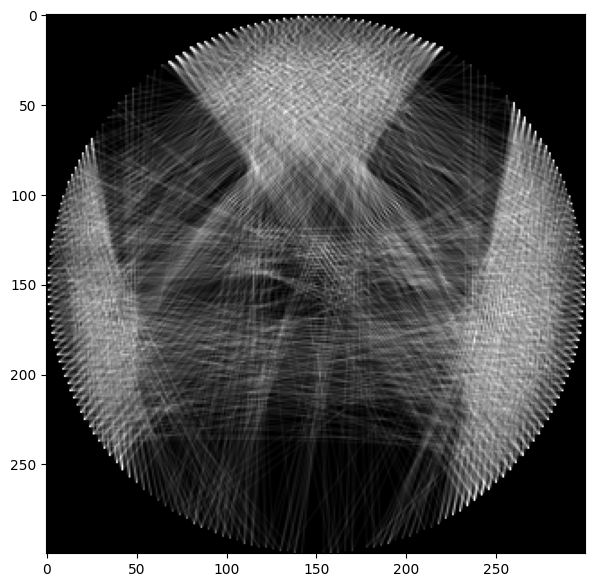

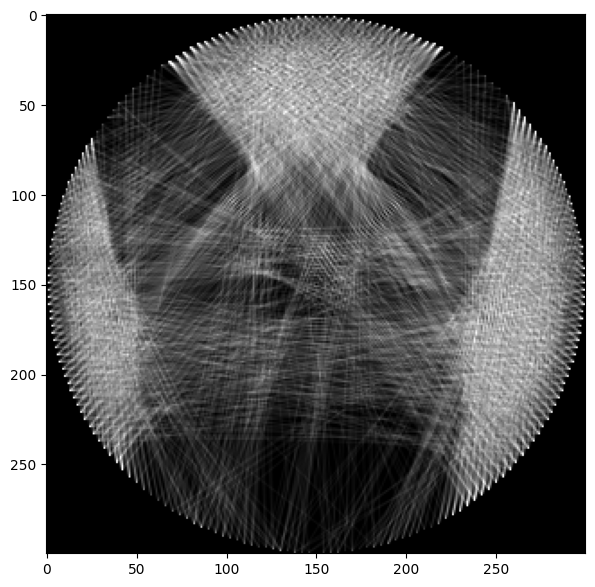

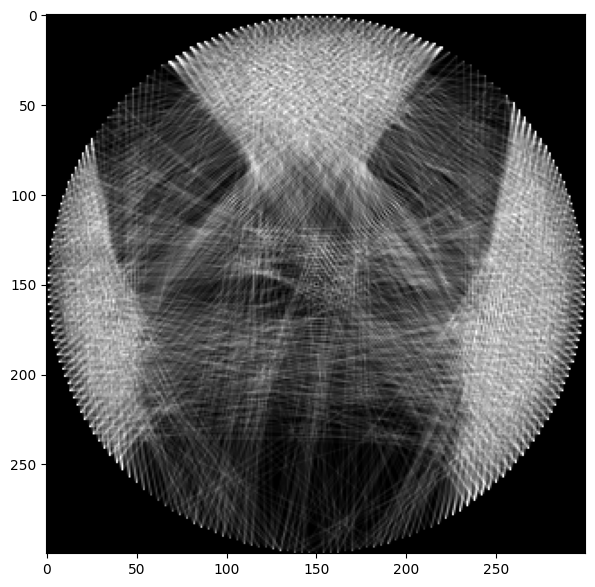

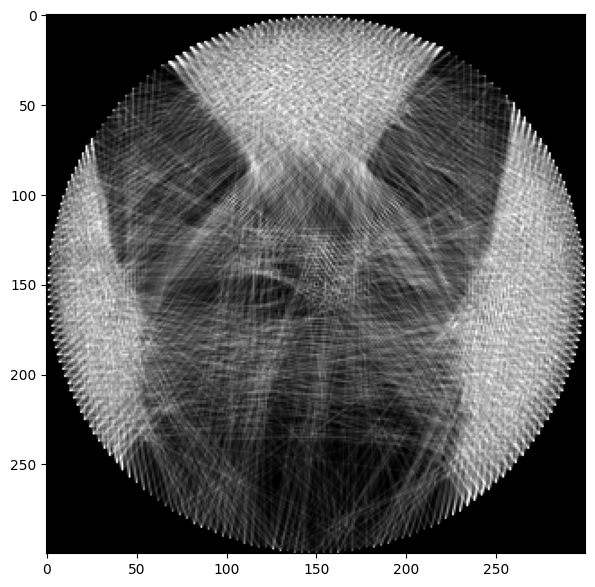

Time: 77.2568302154541
Avg iteration time: 0.03090273208618164


[0,
 97,
 32,
 120,
 41,
 126,
 40,
 125,
 39,
 118,
 36,
 123,
 43,
 127,
 44,
 124,
 37,
 121,
 33,
 111,
 32,
 113,
 34,
 122,
 35,
 116,
 37,
 117,
 38,
 126,
 42,
 128,
 46,
 130,
 48,
 131,
 47,
 129,
 43,
 122,
 36,
 124,
 45,
 128,
 41,
 119,
 38,
 120,
 34,
 110,
 33,
 133,
 34,
 124,
 42,
 121,
 32,
 126,
 48,
 129,
 39,
 117,
 35,
 135,
 80,
 136,
 81,
 138,
 82,
 135,
 81,
 139,
 82,
 137,
 80,
 134,
 33,
 119,
 40,
 118,
 32,
 130,
 45,
 125,
 35,
 112,
 32,
 131,
 44,
 123,
 35,
 114,
 33,
 132,
 50,
 127,
 41,
 131,
 46,
 125,
 42,
 129,
 32,
 124,
 39,
 128,
 51,
 133,
 81,
 137,
 83,
 136,
 84,
 135,
 36,
 113,
 206,
 70,
 203,
 69,
 202,
 70,
 200,
 66,
 198,
 65,
 197,
 63,
 196,
 61,
 195,
 60,
 194,
 59,
 195,
 64,
 198,
 67,
 196,
 62,
 193,
 70,
 204,
 69,
 201,
 66,
 196,
 60,
 193,
 57,
 192,
 70,
 189,
 69,
 194,
 64,
 199,
 67,
 202,
 112,
 205,
 114,
 44,
 128,
 34,
 134,
 83,
 138,
 80,
 132,
 34,
 115,
 43,
 121,
 35,
 111,
 203,
 68,
 195,
 70,
 190,
 68,

In [107]:
nails = create_circle_nail_positions(orig_pic, 4)
str_pic = init_black_canvas(orig_pic)
create_art(nails, orig_pic, str_pic, 0.05)

In [111]:
def scale_nails(x_ratio, y_ratio, nails):
    return [(int(y_ratio*nail[0]), int(x_ratio*nail[1])) for nail in nails]

def circular_pull_order_to_array_bw(order, canvas, nails):
    # Draw a black and white pull order on the defined resolution

    for pull_start, pull_end in zip(order, order[1:]):  # pairwise iteration
        rr, cc, val = line_aa(nails[pull_start][0], nails[pull_start][1],
                              nails[pull_end][0], nails[pull_end][1])
        canvas[rr, cc] += val * -0.1

    return np.clip(canvas, a_min=0, a_max=1)


image_dimens = 900, 900
blank = np.ones((image_dimens[0], image_dimens[1]))
scaled_nails = scale_nails(
    image_dimens[1] / len(orig_pic),
    image_dimens[0] / len(orig_pic[0]),
    nails
)

result = circular_pull_order_to_array_bw(
    pull_order,
    blank,
    scaled_nails
)
mpimg.imsave('outputs/'+name_img, result, cmap=plt.get_cmap("gray"))